In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
from final_processing import final_processing_functions as fpf
import pathlib
from matplotlib import pyplot as plt
import seaborn as sb
import warnings
from matplotlib.lines import Line2D
from scipy.optimize import curve_fit
from scipy.stats import ks_2samp
from allensdk.core.mouse_connectivity_cache import MouseConnectivityCache
from matplotlib import rcParams
import yaml
import figure_formatting as ff
# from matplotlib.ticker import FormatStrFormatter

import matplotlib
warnings.filterwarnings('ignore')
import final_processing.loading_functions as lf
import final_processing.MAPseq_data_processing as mdp
import statsmodels.formula.api as smf
import final_processing.fig2_plotting as pltt
import final_processing.helper_functions as hf
%matplotlib inline

/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/flexiznam/schema/sequencing_data.py:11: UserWarning: Could not find `sequencing_extensions` in config. Please update config file
  class SequencingData(Dataset):
/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/setuptools/_distutils/version.py:337: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/camp/home/turnerb/.conda/envs/MAPseq_processing/lib/python3.8/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/camp/home/turnerb/.conda/envs/

Load filepaths and perform area assignment

In [14]:
gen_parameters = lf.load_gen_params()
mice = gen_parameters['MICE']
saving_path = gen_parameters['fig_saving_path']
proj_path = gen_parameters['proj_path']
ff.set_font_params(gen_parameters)


In [3]:
#load all mice neuron projection datasets
combined_dict = mdp.samples_to_areas(mice = mice, proj_path=proj_path)
all_mice_combined = pd.concat([
    combined_dict[k]['homogenous_across_cubelet'][mdp.get_common_columns(mice=mice, combined_dict=combined_dict, cortex=True)]
    for k in mice
])

Fig 2b-c

KS = 0.20 (p=0.71), r  = 0.79 (p=2.3e-06)
KS = 0.24 (p=0.475), r  = 0.73 (p=4e-05)


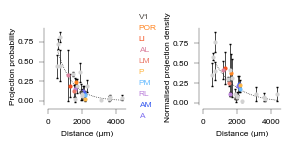

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(3, 1))

pltt.plot_all_distance_decay_from_A1(
    fig,
    axes,
    combined_dict=combined_dict,
    all_mice_combined=all_mice_combined,
    mice=mice,
    gen_parameters=gen_parameters,
)
fig.savefig(f"{saving_path}/fig2_dist_vs_proj.pdf", format="pdf")
fig.savefig(f"{saving_path}/fig2_dist_vs_proj.svg", format="svg")

Fig. 2e

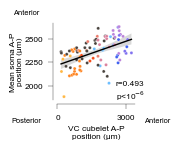

In [59]:
fig, ax = plt.subplots(figsize=(1, 1))
AP_position_dict_list_combined, AP_soma_VC_sample = mdp.compute_mean_soma_AP_positions(gen_parameters=gen_parameters)
pltt.plot_ap_vs_visap(ax, AP_soma_VC_sample, gen_parameters)
fig.savefig(f"{saving_path}/fig_2_AP_vs_VISAP.svg", format="svg")
fig.savefig(f"{saving_path}/fig_2_AP_vs_VISAP.pdf", format="pdf")

Fig. 2f

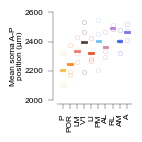

In [61]:
where_AP_vis, area_AP_dict = mdp.get_area_mean_AP(gen_parameters=gen_parameters, combined_dict=combined_dict, AP_position_dict_list_combined=AP_position_dict_list_combined)
fig, ax = plt.subplots(figsize=(1.4, 1.4))
pltt.plot_area_AP_positions(
    ax=ax,
    fig=fig,
    area_AP_dict=area_AP_dict,
    where_AP_vis=where_AP_vis,
    font_size=gen_parameters["font_size"],
)
fig.savefig(f"{saving_path}/fig2_meanAP_pos_area.svg", format="svg")
fig.savefig(f"{saving_path}/fig2_meanAP_pos_area.pdf", format="pdf")



Fig. 2g

p value for VISam is 0.014
p value for VISrl is 1.8e-22
p value for VISpor is 4.2e-28
p value for VISpl is 4.2e-10


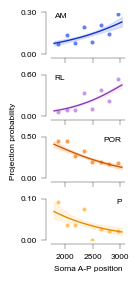

In [70]:
areas_to_plot = ['VISam', 'VISrl', 'VISpor', 'VISpl']
fig, axes = plt.subplots(
    nrows=4,          
    ncols=1,        
    figsize=(1.4, 2.8),
    sharex=True       
)
pltt.plot_area_projection_probs(areas_to_plot=areas_to_plot, gen_parameters=gen_parameters, combined_dict=combined_dict, AP_position_dict_list_combined=AP_position_dict_list_combined, fig=fig, axes=axes)
fig.savefig(f"{saving_path}/fig2_proj_prob_AP.svg", format="svg")
fig.savefig(f"{saving_path}/fig2_proj_prob_AP.pdf", format="pdf")


Fig. 2h

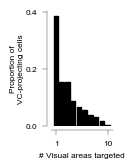

In [20]:
fig, ax = plt.subplots(figsize=(0.8, 1.5))  
pltt.plot_vc_projecting_cells(visual_areas=gen_parameters['HVA_cols'], all_mice=all_mice_combined, fig=fig, ax=ax, gen_parameters=gen_parameters)
fig.savefig(f"{saving_path}/vc_projection_counts.pdf", format="pdf")
fig.savefig(f"{saving_path}/vc_projection_counts.svg", format="svg")


Fig. 2i-j

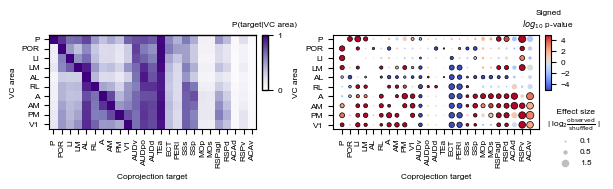

In [ ]:
fig = plt.figure(figsize=(15/2.54, 4/2.54))
pltt.plot_the_heatmap_and_bubble(gen_parameters=gen_parameters, all_mice_combined=all_mice_combined, fig=fig)
plt.savefig(f"{saving_path}/fig_2_heatmapbubble_combined.svg", format="svg")
plt.savefig(f"{saving_path}/fig_2_heatmapbubble_combined.pdf", format="pdf")


Fig. 2k-m

Dorsal-Dorsal vs Dorsal-Ventral: U=109.000, p=0.0015
Ventral-Ventral vs Dorsal-Ventral: U=79.000, p=0.3671
Ventral-Ventral vs Dorsal-Dorsal: U=14.000, p=0.0934


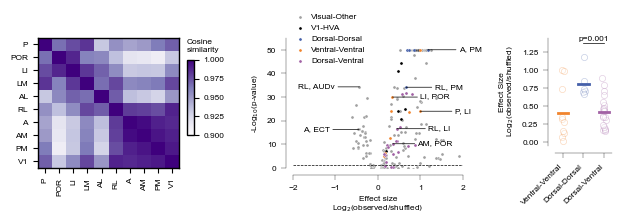

In [57]:
cosine_df = mdp.cal_cosine_sim(gen_parameters=gen_parameters, all_mice_combined=all_mice_combined)
to_plot = mdp.perform_motif_analysis(gen_parameters=gen_parameters, barcodes=all_mice_combined)

fig = plt.figure(figsize=(18/2.54, 5.5/2.54))
ax = fig.add_axes([0.1, 0.25, 0.2, 0.6])
cbax = fig.add_axes([0.31, 0.4, 0.01, 0.35])
pltt.add_cosine_sim_plot(ax=ax, cbax=cbax, cosine_df=cosine_df, gen_parameters=gen_parameters)
ax = fig.add_axes([0.46, 0.25, 0.24, 0.6])
pltt.add_motif_volcano_plot(gen_parameters=gen_parameters, to_plot=to_plot, ax=ax)
ax = fig.add_axes([0.83, 0.35, 0.08, 0.5])
pltt.plot_stream_effects(ax=ax, to_plot=to_plot, gen_parameters=gen_parameters)


fig.savefig(f"{saving_path}/fig2_stream_effectsize.svg", format="svg")
fig.savefig(f"{saving_path}/fig2_stream_effectsize.pdf", format="pdf")
